**<h1> Multivariate Prediction For Weather using LSTM</h1>**

We will be doing a multivariate analysis for weather prediction.

**<h2> Importing Libraries</h2>**

In [1]:
import sys
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import math
import os
import h5py
import tensorflow as tf
print(tf.__version__)

2.3.0


**<h2>Mounting Drive</h2>**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**<h2> Windowing Function </h2>**

It will return the windowed data to us.

In [ ]:
def windowed_dataset(series, window_size = 17,predday = 1, batch_size = 17, shuffle_buffer= 100):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-predday], tf.squeeze(w[-predday:])))
    return ds.batch(batch_size).prefetch(1)

**<h2>Uploading Data</h2>**

In [ ]:
import pandas as pd
weather_data = pd.read_csv(r"/content/drive/My Drive/weather/lucknow1.csv")
weather_data.head()

,Year,Month,tmax(degC),tmin(degC),ppt(mm)
0,1958,1,24.3,10.5,32
1,1958,2,26.8,11.6,3
2,1958,3,33.6,16.9,24
3,1958,4,39.8,23.4,1
4,1958,5,41.8,27.1,3


**<h2>Preprocessing Data </h2>**

In [ ]:
window=17
cut=int(weather_data.shape[0]*0.8)

In [ ]:
weather_data.columns

Index(['Year', 'Month', 'tmax(degC)', 'tmin(degC)', 'ppt(mm)'], dtype='object')

In [ ]:
weather = weather_data[ ["tmax(degC)","tmin(degC)","ppt(mm)"]].values

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
weather = scaler.fit_transform(weather)
weather[:2]

array([[-1.42510128, -1.26976712, -0.41560113],
       [-0.97459508, -1.11747545, -0.67052679]])

In [ ]:
train = weatheforecast = weather[-(window):]r[:cut]
test = weather[cut:(-window)]
forecast = weather[-(window):]
print(train.shape , test.shape, forecast.shape)

(595, 3) (132, 3) (17, 3)


In [ ]:
trainbatches = windowed_dataset(train)
testbatches = windowed_dataset(test)

**<h2> LSTM Model</h2>**

In [ ]:
from tensorflow.keras import layers
model = tf.keras.Sequential()
model.add(layers.LSTM(32,input_shape=[None,3],return_sequences=True))
model.add(layers.LSTM(32,return_sequences=True))
model.add(layers.LSTM(16,return_sequences=True))
model.add(layers.Dense(3,activation="selu"))
optimizer = tf.keras.optimizers.Adam()
kl = tf.keras.losses.MeanSquaredError()
model.compile(optimizer = optimizer, loss =kl)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 32)          4608      
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 16)          3136      
_________________________________________________________________
dense (Dense)                (None, None, 3)           51        
Total params: 16,115
Trainable params: 16,115
Non-trainable params: 0
_________________________________________________________________


In [ ]:
h = model.fit(trainbatches,epochs=100,verbose=1)
hist = h.history


Epoch 1/100
34/34 [==============================] - 1s 20ms/step - loss: 0.9993
Epoch 2/100
34/34 [==============================] - 1s 20ms/step - loss: 0.9994
Epoch 3/100
34/34 [==============================] - 1s 22ms/step - loss: 0.9993
Epoch 4/100
34/34 [==============================] - 1s 20ms/step - loss: 0.9983
Epoch 5/100
34/34 [==============================] - 1s 20ms/step - loss: 0.9991
Epoch 6/100
34/34 [==============================] - 1s 20ms/step - loss: 1.0003
Epoch 7/100
34/34 [==============================] - 1s 22ms/step - loss: 0.9987
Epoch 8/100
34/34 [==============================] - 1s 20ms/step - loss: 0.9992
Epoch 9/100
34/34 [==============================] - 1s 20ms/step - loss: 0.9985
Epoch 10/100
34/34 [==============================] - 1s 20ms/step - loss: 1.0004
Epoch 11/100
34/34 [==============================] - 1s 20ms/step - loss: 0.9987
Epoch 12/100
34/34 [==============================] - 1s 20ms/step - loss: 0.9987
Epoch 13/100
34/34 [=====

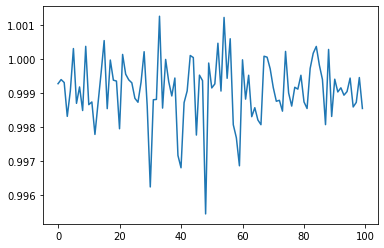

In [ ]:
plt.plot(hist["loss"])
plt.show()

**<h2>Predicting Outcomes</h2>**

In [ ]:
x,y = next(iter(testbatches))
output = model.predict(x)
output.shape

(17, 17, 3)

In [ ]:
p = output.reshape(-3,3)
p.shape

(289, 3)

In [ ]:
p = scaler.inverse_transform(p)

In [ ]:
p=p.reshape(-1,1)
p.shape

(867, 1)

In [ ]:

forecast_rain = []
forecast_min=[]
forecast_max = []
for i in range(0,len(p),51):
  forecast_max.append(p[i]*100)
  forecast_min.append(p[i+1]*100)
  forecast_rain.append(p[i+2])

print(len(forecast_max),len(forecast_min),len(forecast_rain))

17 17 17


In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
forecast_rain

[array([80.473755], dtype=float32),
 array([78.78191], dtype=float32),
 array([80.43673], dtype=float32),
 array([80.6911], dtype=float32),
 array([79.79448], dtype=float32),
 array([79.87106], dtype=float32),
 array([80.368996], dtype=float32),
 array([80.55778], dtype=float32),
 array([80.91973], dtype=float32),
 array([80.686325], dtype=float32),
 array([79.30123], dtype=float32),
 array([80.43732], dtype=float32),
 array([80.15174], dtype=float32),
 array([80.08134], dtype=float32),
 array([80.55795], dtype=float32),
 array([80.89307], dtype=float32),
 array([80.70153], dtype=float32)]

**<h2>Saving Necessary Models</h2>**

In [ ]:
model.save("/content/drive/My Drive/weather/models/weather.h5")


In [ ]:
np.save("/content/drive/My Drive/weather/models/weather_data.npy",weather)